-Fill na for categorical columns by ffill
-Encode categorical columns by target encoding

cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type","GPU: Name",
"CPU: Name"]
-Split train set and test set
-Draw corr heat map for numerical feature

numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight","Num of M.2 Slot","Ethernet LAN","USB Type-C","USB Type-A","HDMI","Bluetooth","CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency","CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography","GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size","GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]

-Draw corr heatmap for those chosen feature
-Fill na for chosen numerical feature
-Using mutual information to select kbest for cat feature
-Draw some graph
-Using technique to concat some of those feature into a new one
-PCA
-Model

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import sklearn as sk
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, f_classif, SelectKBest
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score,root_mean_squared_error
from prettytable import PrettyTable
import random

In [2]:
laptop_data=pd.read_csv("../data/laptop_final.csv")
laptop_data.head()

,link,name,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,...,GPU: Name,GPU: Process Size (nm),GPU: Architecture,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption
0,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Strix G17,17.3,2560.0,1440.0,240.0,IPS + G-Sync,2000.0,1.0,0.0,...,"geforce rtx 4060 (laptop, 140w)",4.0,Ada Lovelace,DDR6,2000.0,8.0,1920.0,128.0,2023.0,140.0
1,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Zephyrus Duo 16,16.0,2560.0,1600.0,240.0,IPS + FreeSync,16000.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Zephyrus Duo 16,16.0,2560.0,1600.0,240.0,IPS + FreeSync,2000.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Zephyrus Duo 16,16.0,2560.0,1600.0,240.0,IPS + FreeSync,2000.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Strix G17,17.3,2560.0,1440.0,240.0,IPS + G-Sync,2000.0,1.0,0.0,...,"geforce rtx 4060 (laptop, 140w)",4.0,Ada Lovelace,DDR6,2000.0,8.0,1920.0,128.0,2023.0,140.0


In [3]:
target="Work Score"

In [4]:
laptop_data2=laptop_data.drop(columns=["link","name","Total Score","Portability Score","Display Score","Play Score","Cost","CPU: Codename"])
laptop_data2

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Name,GPU: Process Size (nm),GPU: Architecture,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption
0,17.3,2560.0,1440.0,240.0,IPS + G-Sync,2000.0,1.0,0.0,0.0,0.0,...,"geforce rtx 4060 (laptop, 140w)",4.0,Ada Lovelace,DDR6,2000.0,8.0,1920.0,128.0,2023.0,140.0
1,16.0,2560.0,1600.0,240.0,IPS + FreeSync,16000.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,2560.0,1600.0,240.0,IPS + FreeSync,2000.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.0,2560.0,1600.0,240.0,IPS + FreeSync,2000.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17.3,2560.0,1440.0,240.0,IPS + G-Sync,2000.0,1.0,0.0,0.0,0.0,...,"geforce rtx 4060 (laptop, 140w)",4.0,Ada Lovelace,DDR6,2000.0,8.0,1920.0,128.0,2023.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289166,17.3,1920.0,1080.0,60.0,IPS,256.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289167,17.3,1600.0,900.0,60.0,TN,256.0,1.0,0.0,0.0,0.0,...,iris xe graphics g4,10.0,Tiger Lake GT2,shared,0.0,0.0,300.0,0.0,2020.5,15.0
289168,17.3,1600.0,900.0,60.0,TN,2256.0,1.0,1.0,0.0,0.0,...,iris xe graphics g4,10.0,Tiger Lake GT2,shared,0.0,0.0,300.0,0.0,2020.5,15.0
289169,17.3,1600.0,900.0,60.0,TN,1512.0,1.0,1.0,0.0,0.0,...,iris xe graphics g4,10.0,Tiger Lake GT2,shared,0.0,0.0,300.0,0.0,2020.5,15.0


Drop every na work score

In [5]:
laptop_data2.dropna(subset=["Work Score"],inplace=True)

In [6]:
laptop_data2.shape

(230531, 54)

In [7]:
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","Ethernet LAN","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]
categorical_features=list(set(laptop_data2.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type","GPU: Name",
"CPU: Name"]

['Body material: magnesium-lithium alloy', 'Fingerprint reader', 'Body material: black synthetic material', 'GPU: Memory Type', 'Backlit keyboard', 'RAM Type', 'SSD', 'Card Reader', 'Body material: aluminum', 'CPU: Name', 'Security Lock slot', 'HDD', 'Optane', 'GPU: Architecture', 'Panel Type', 'Body material: carbon', 'Body material: plastic / polycarbonate', 'OS', 'Body material: magnesium alloy', 'Body material: plastic', 'GPU: Name', 'SSHD', 'Body material: glass fiber', 'Body material: matte']
24


Fill na 

In [8]:
na_cols={}
for cols in laptop_data2:
    na=laptop_data2[cols].isna().sum()
    if na!=0:
        na_cols[cols]=na
for k,v in na_cols.items():
    print(f"{k}:{v}")

RAM Capacity:248
RAM Type:34053
OS:427
Dimension: Depth:977
Weight:622
Ethernet LAN:55010
CPU: Max operating temperature:67
CPU: Base frequency:34
CPU: Release quarter:843
CPU: LL Cache:8
GPU: Name:2
GPU: Process Size (nm):39
GPU: Architecture:14826
GPU: Memory Type:2
GPU: Memory Frequency (MHz):2
GPU: Memory Size:2
GPU: Base Clock:23326
GPU: Memory Bus:2
GPU: Release quarter:2
GPU: Power Consumption:2003


In [9]:
for col in na_cols:
    laptop_data2[col]=laptop_data2[col].fillna(method="ffill")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2092\3774050326.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  laptop_data2[col]=laptop_data2[col].fillna(method="ffill")


In [11]:
laptop_data2[categorical_features].isna().sum()

GPU: Memory Type                           0
Body material: magnesium alloy             0
GPU: Name                                  0
HDD                                        0
SSHD                                       0
RAM Type                                   0
SSD                                        0
OS                                         0
Backlit keyboard                           0
GPU: Architecture                          0
Fingerprint reader                         0
CPU: Name                                  0
Body material: aluminum                    0
Panel Type                                 0
Optane                                     0
Body material: matte                       0
Card Reader                                0
Body material: plastic                     0
Body material: glass fiber                 0
Body material: magnesium-lithium alloy     0
Body material: plastic / polycarbonate     0
Body material: carbon                      0
Body mater

Divide to train and test set

In [10]:
X=laptop_data2.drop(columns=[target])
y=laptop_data2[target]

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=111)

Encode categorical columns using target encoding

In [12]:
for col in cols_to_encode:
    print(f"Number of categories in {col}: ",laptop_data2[col].nunique())

Number of categories in Panel Type:  12
Number of categories in RAM Type:  5
Number of categories in OS:  11
Number of categories in GPU: Architecture:  48
Number of categories in GPU: Memory Type:  4
Number of categories in GPU: Name:  272
Number of categories in CPU: Name:  214


In [13]:
encoder=TargetEncoder(cols=cols_to_encode)

In [14]:
X_train=encoder.fit_transform(X_train,y_train)
X_test=encoder.transform(X_test)

In [15]:
X_train

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Name,GPU: Process Size (nm),GPU: Architecture,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption
192978,15.6,1920.0,1080.0,60.0,6.335125,512.0,1.0,0.0,0.0,0.0,...,5.430514,10.0,5.639518,5.625279,0.0,0.0,300.0,0.0,2020.50,15.0
215803,17.3,1600.0,900.0,60.0,5.163328,2000.0,1.0,0.0,0.0,0.0,...,5.939828,10.0,5.639518,5.625279,0.0,0.0,300.0,0.0,2020.50,15.0
89559,15.6,1920.0,1080.0,120.0,6.335125,256.0,1.0,0.0,0.0,0.0,...,7.145445,8.0,6.837517,7.162982,12000.0,4.0,1222.0,128.0,2021.25,80.0
60435,15.6,1920.0,1080.0,144.0,6.335125,512.0,1.0,0.0,0.0,0.0,...,7.033271,6.0,7.032727,7.162982,1750.0,4.0,1550.0,64.0,2022.00,35.0
208352,15.6,1920.0,1080.0,60.0,6.335125,2000.0,1.0,1.0,0.0,0.0,...,5.939828,10.0,5.639518,5.625279,0.0,0.0,300.0,0.0,2020.50,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107446,17.3,1600.0,900.0,60.0,5.163328,1000.0,1.0,0.0,0.0,0.0,...,5.939828,10.0,5.639518,5.625279,0.0,0.0,300.0,0.0,2020.50,15.0
141839,15.6,1920.0,1080.0,60.0,5.163328,256.0,1.0,0.0,0.0,0.0,...,5.392093,10.0,5.393869,5.625279,0.0,0.0,300.0,0.0,2022.00,45.0
10651,14.0,2880.0,1800.0,120.0,6.978078,1000.0,1.0,0.0,0.0,0.0,...,7.140613,5.0,6.926494,5.625279,0.0,0.0,1290.0,0.0,2023.75,110.0
135179,14.0,1920.0,1080.0,60.0,6.335125,8000.0,1.0,0.0,0.0,0.0,...,5.430514,10.0,5.639518,5.625279,0.0,0.0,300.0,0.0,2020.50,15.0


Using mutual info and anova to find the most relevant categorical features

In [16]:
#mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(X_train[categorical_features],y_train)

SelectKBest(score_func=<function mutual_info_regression at 0x000001582CE651C0>)

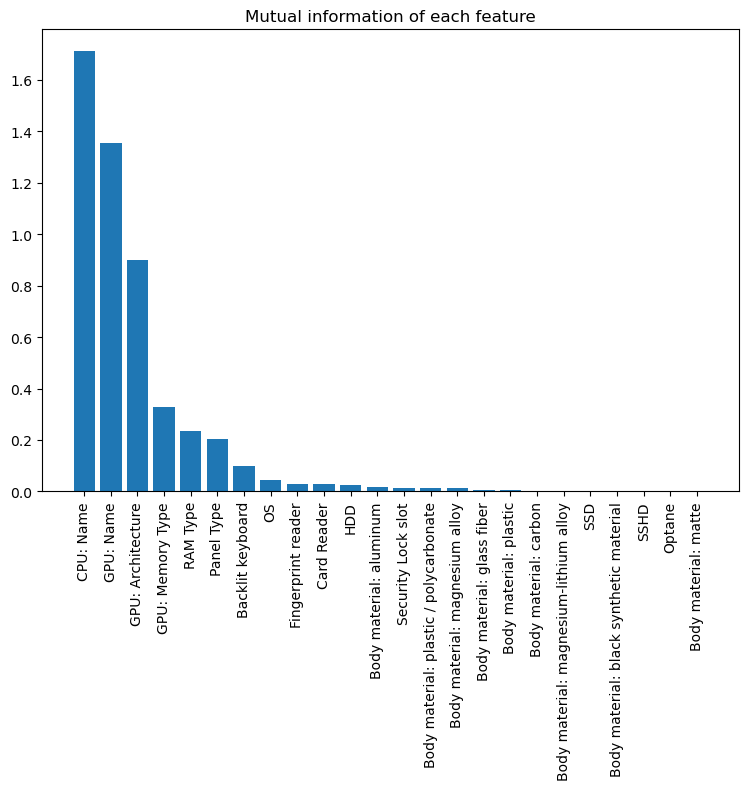

In [17]:
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

In [18]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(X_train[categorical_features],y_train)
fs2.get_feature_names_out()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 2 19 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


array(['GPU: Memory Type', 'Backlit keyboard', 'RAM Type', 'Card Reader',
       'CPU: Name', 'Optane', 'GPU: Architecture', 'Panel Type', 'OS',
       'GPU: Name'], dtype=object)

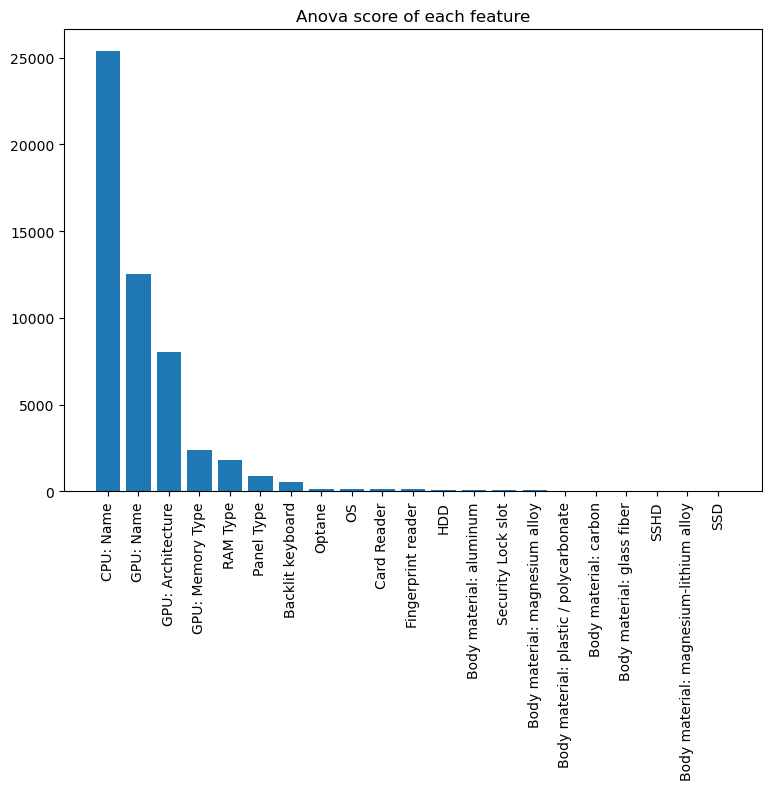

In [20]:
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

In [21]:
categorical_features_to_keep=["CPU: Name","GPU: Name","GPU: Architecture","GPU: Memory Type","RAM Type",
                              "Panel Type","Backlit keyboard"]

In [22]:
def show_top(feature,descending=True,n=20):
    mean_target=laptop_data2.groupby(feature)[target].mean()
    std_target=laptop_data2.groupby(feature)[target].std()
    summary_df=pd.DataFrame({"mean":mean_target,"std":std_target})
    if descending:
        top_n=summary_df.nlargest(n=n,columns=["mean"])
    else: 
        top_n=summary_df.nsmallest(n=n,columns=["mean"])
    plt.figure(figsize=(15,6))
    plt.bar(top_n.index,top_n["mean"],yerr=top_n["std"],color="lightblue")
    plt.xticks(rotation=60)
    plt.xlabel(feature)
    plt.ylabel(f'Mean {target}')
    plt.show()

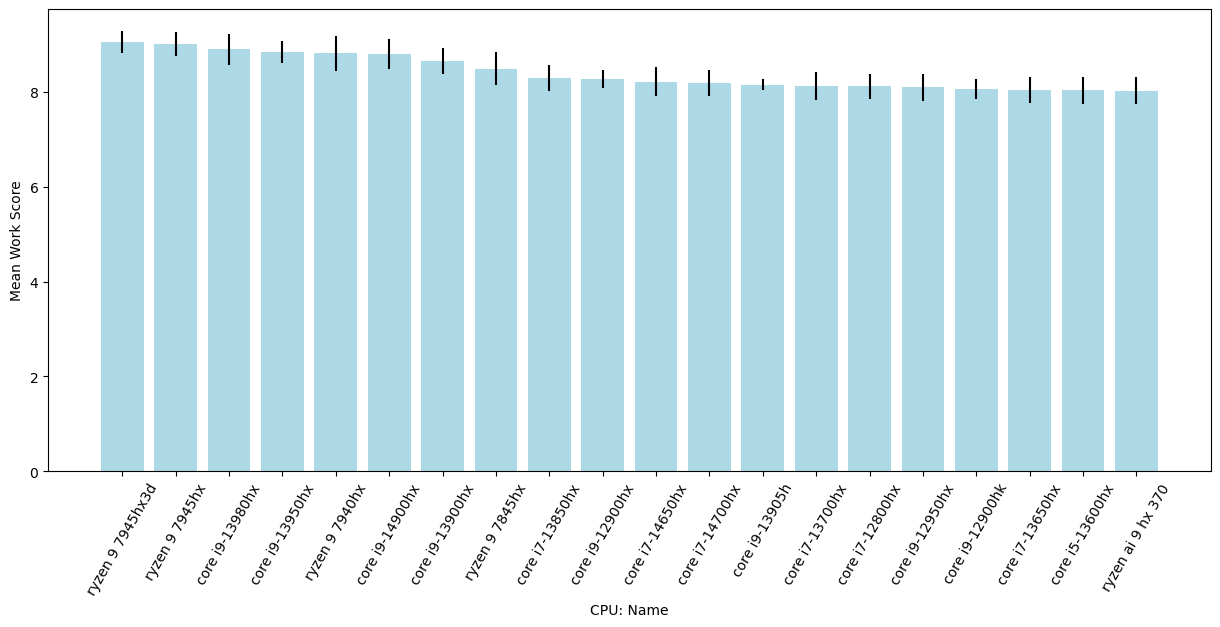

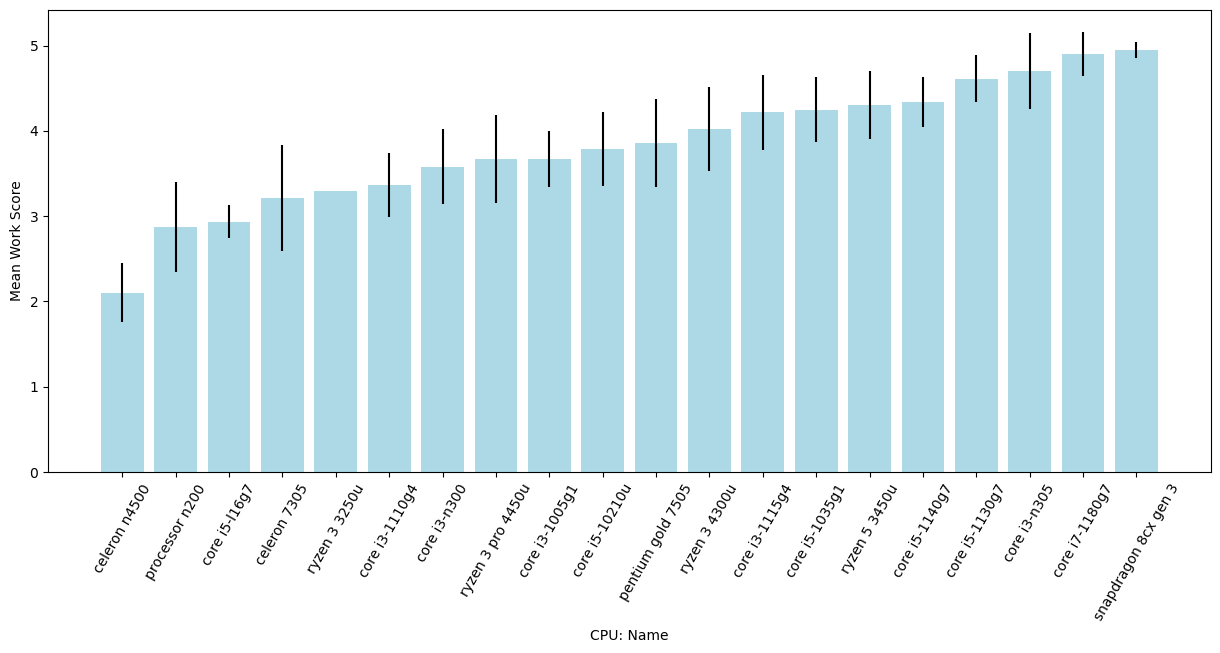

In [23]:
show_top("CPU: Name")
show_top("CPU: Name",descending=False)

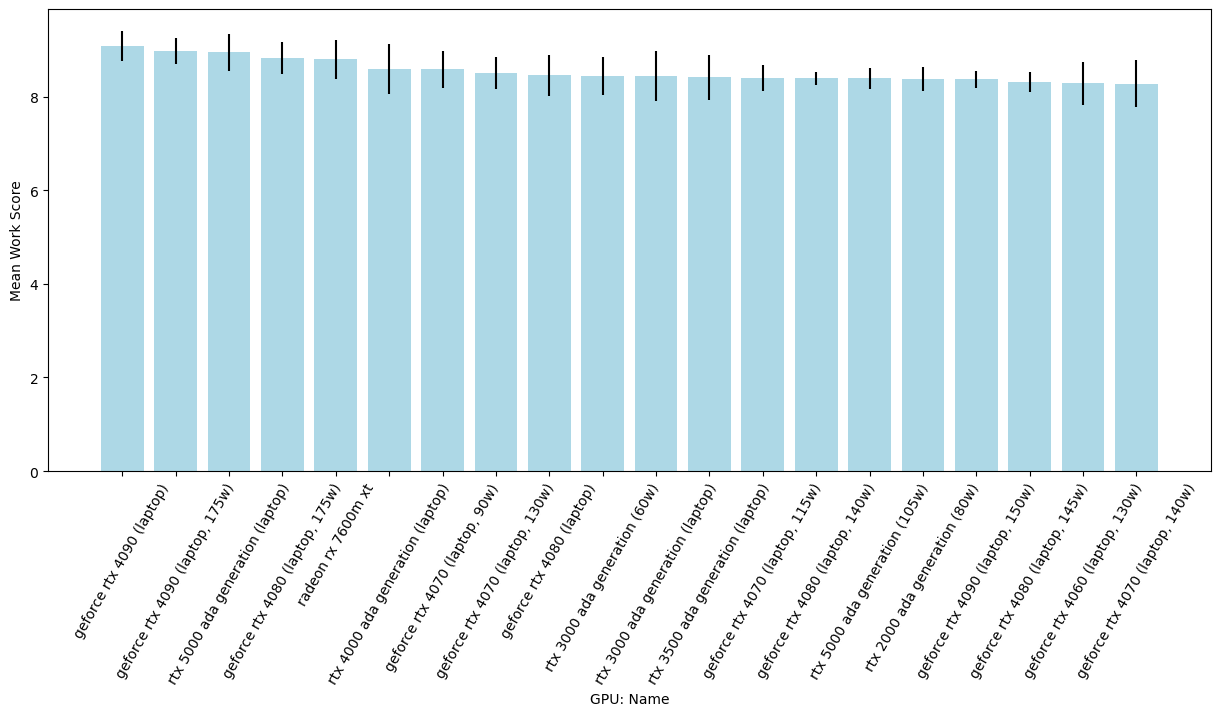

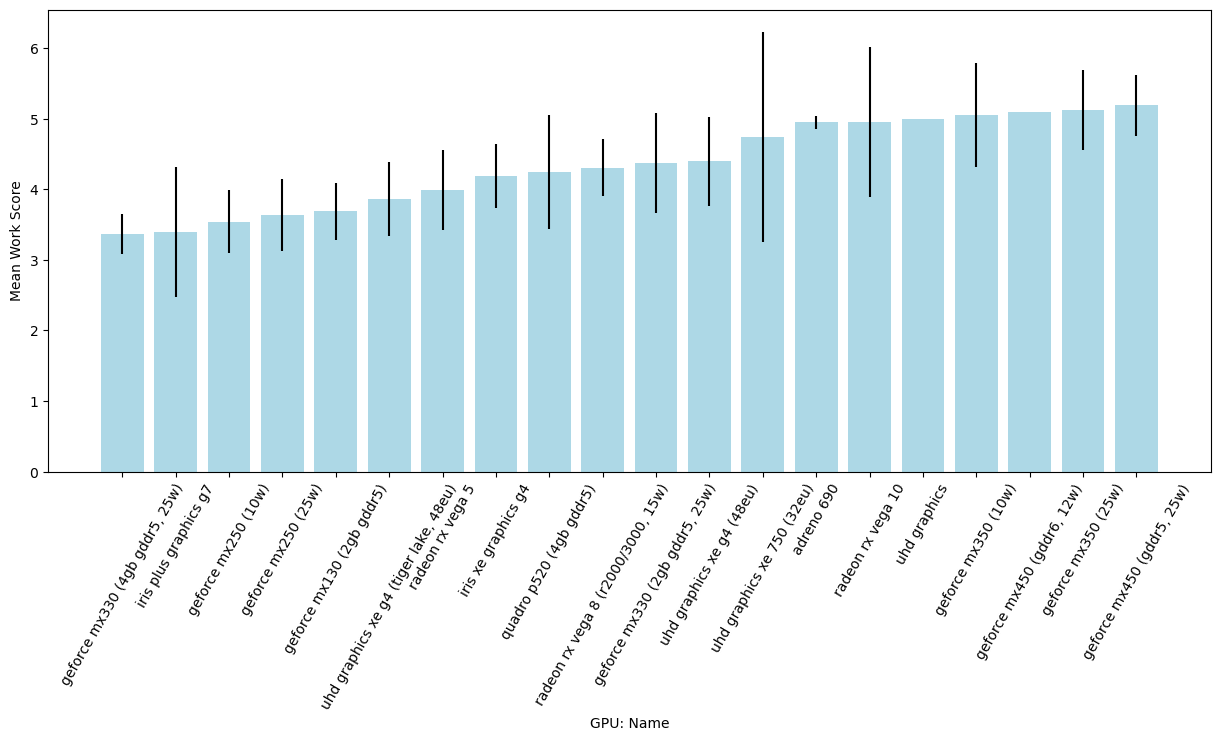

In [24]:
show_top("GPU: Name")
show_top("GPU: Name",descending=False)

Using pearson correlation to find the most relevant numerical features

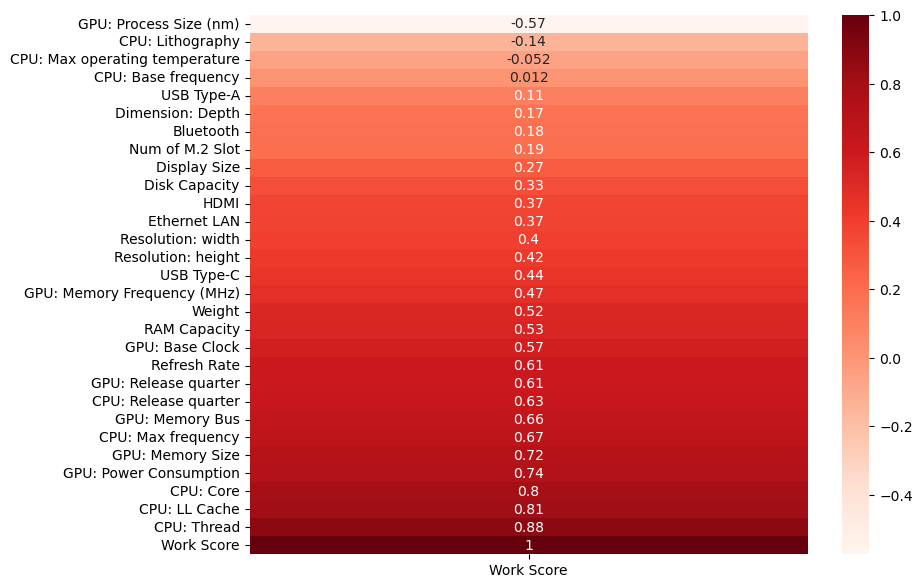

In [25]:
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

In [26]:
numerical_features_to_keep=[f for f in target_correlation.index if abs(target_correlation[target].loc[f])>=0.5]
numerical_features_to_keep.remove(target)
numerical_features_to_keep

['Refresh Rate',
 'RAM Capacity',
 'Weight',
 'CPU: Core',
 'CPU: Thread',
 'CPU: Max frequency',
 'CPU: Release quarter',
 'CPU: LL Cache',
 'GPU: Process Size (nm)',
 'GPU: Memory Size',
 'GPU: Base Clock',
 'GPU: Memory Bus',
 'GPU: Release quarter',
 'GPU: Power Consumption']

Remove redundant features that are highly correlated with other

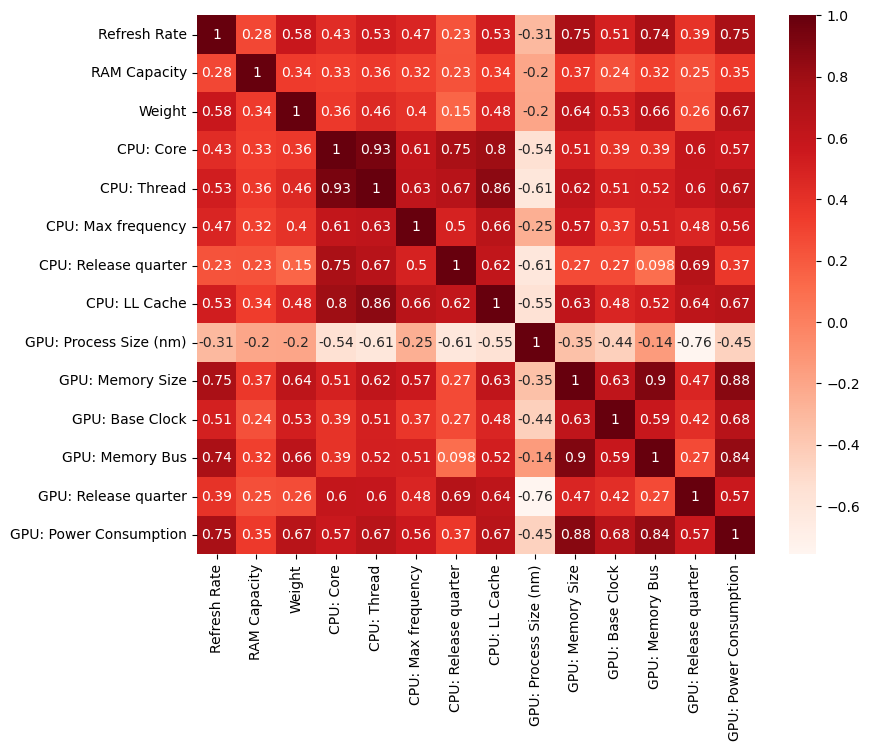

In [27]:
plt.figure(figsize=(9,7))
sns.heatmap(train_set.corr().loc[numerical_features_to_keep, numerical_features_to_keep], annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#CPU_thread  are highly correlated with CPU_core(0.93) and CPU: LL cache(0.86), 
# We choose feature with higheest correlation with the target - CPU_thread and remove the other 2 features.
#GPU: Power Consumption are highly correlated with GPU: Memory Size(0.88) and GPU: Memory Bus(0.84). 
# We keep GPU: Power Consumpition 
#GPU: Release Quarter are highly correlated with GPU: Process size(nm) (-0.76). 
# We keep GPU: Release Quarter 

In [28]:
numerical_features_to_keep=['Refresh Rate','RAM Capacity','Weight','CPU: Thread','CPU: Max frequency',
'CPU: Release quarter','GPU: Base Clock','GPU: Release quarter','GPU: Power Consumption']

In [29]:
corr_df_sample=corr_df.sample(30000)
def scatter_vis(ax,feature):
    ax.scatter(corr_df_sample[feature],corr_df_sample[target],c="r",linewidths=0.3,edgecolors="black")
    ax.set_xlabel(feature)

Text(0.5, 0.98, 'Scatter plots representing correlation of each numerical features and Work Score ')

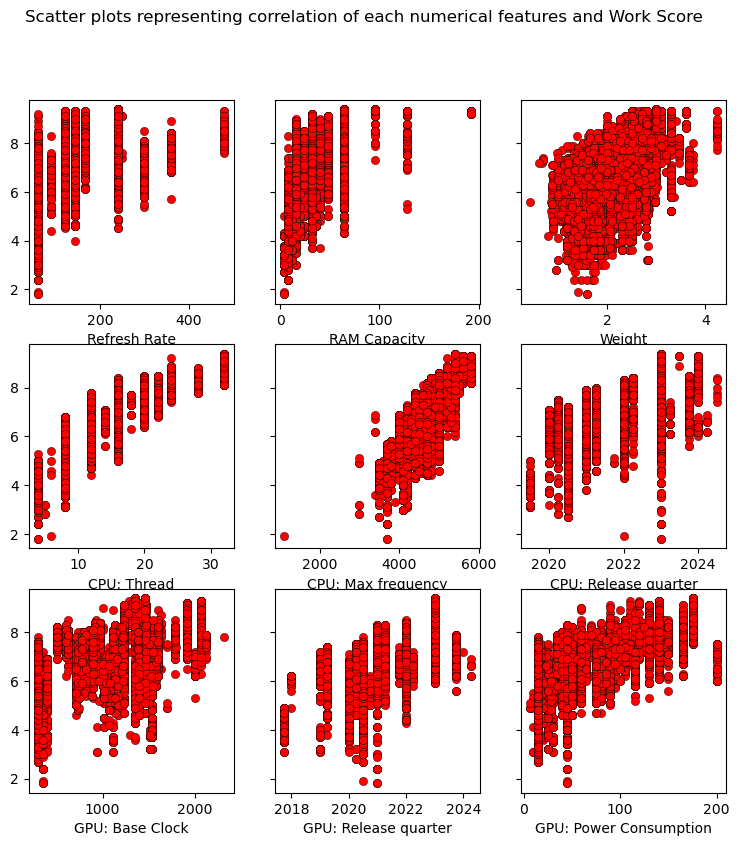

In [30]:
fig,axes=plt.subplots(nrows=3,ncols=3,figsize=(9,9),sharey=True)
for i in range(3):
    for j in range(3):
        scatter_vis(axes[i,j],numerical_features_to_keep[i*3+j])
fig.suptitle(f"Scatter plots representing correlation of each numerical features and {target} ")

Transform X_train,X_test

In [31]:
features_to_keep=numerical_features_to_keep+categorical_features_to_keep
print("Number of features:",len(features_to_keep))
features_to_keep

Number of features: 16


['Refresh Rate',
 'RAM Capacity',
 'Weight',
 'CPU: Thread',
 'CPU: Max frequency',
 'CPU: Release quarter',
 'GPU: Base Clock',
 'GPU: Release quarter',
 'GPU: Power Consumption',
 'CPU: Name',
 'GPU: Name',
 'GPU: Architecture',
 'GPU: Memory Type',
 'RAM Type',
 'Panel Type',
 'Backlit keyboard']

In [32]:
X_train=X_train[features_to_keep]
X_test=X_test[features_to_keep]

Normalize numerical features

In [33]:
scaler=StandardScaler()

In [34]:
X_train[numerical_features_to_keep]=scaler.fit_transform(X_train[numerical_features_to_keep])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2092\2913540577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_features_to_keep]=scaler.fit_transform(X_train[numerical_features_to_keep])


In [35]:
X_train

,Refresh Rate,RAM Capacity,Weight,CPU: Thread,CPU: Max frequency,CPU: Release quarter,GPU: Base Clock,GPU: Release quarter,GPU: Power Consumption,CPU: Name,GPU: Name,GPU: Architecture,GPU: Memory Type,RAM Type,Panel Type,Backlit keyboard
192978,-0.672574,-0.618837,-0.477487,-0.940112,-1.040002,-0.904916,-1.052257,-0.352047,-0.868207,5.161529,5.430514,5.639518,5.625279,5.997412,6.335125,1.0
215803,-0.672574,0.235934,0.036353,-0.940112,0.283392,-0.904916,-1.052257,-0.352047,-0.868207,5.381660,5.939828,5.639518,5.625279,5.997412,5.163328,0.0
89559,0.244195,0.235934,0.837944,0.488710,1.077428,-0.904916,0.690250,0.373192,0.445842,6.772885,7.145445,6.837517,7.162982,5.997412,6.335125,1.0
60435,0.610902,-0.618837,-0.354165,-0.225701,-0.510645,0.587060,1.310144,1.098430,-0.463884,6.788732,7.033271,7.032727,7.162982,5.997412,6.335125,1.0
208352,-0.672574,-0.618837,-0.621362,-0.940112,0.283392,-0.904916,-1.052257,-0.352047,-0.868207,5.381660,5.939828,5.639518,5.625279,5.997412,6.335125,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107446,-0.672574,0.235934,0.036353,-0.225701,0.283392,0.587060,-1.052257,-0.352047,-0.868207,6.273838,5.939828,5.639518,5.625279,5.997412,5.163328,1.0
141839,-0.672574,-1.046222,-0.683023,-0.940112,-0.510645,0.587060,-1.052257,1.098430,-0.261723,5.254962,5.392093,5.393869,5.625279,5.997412,5.163328,0.0
10651,0.244195,-0.618837,-1.505167,1.560327,1.342107,2.327699,0.818765,2.790653,1.052325,7.914527,7.140613,6.926494,5.625279,7.603423,6.978078,1.0
135179,-0.672574,1.945475,-0.785791,-0.940112,-0.245966,-0.158928,-1.052257,-0.352047,-0.868207,5.464851,5.430514,5.639518,5.625279,5.997412,6.335125,1.0


In [36]:
X_test[numerical_features_to_keep]=scaler.fit_transform(X_test[numerical_features_to_keep])

In [37]:
X_test

,Refresh Rate,RAM Capacity,Weight,CPU: Thread,CPU: Max frequency,CPU: Release quarter,GPU: Base Clock,GPU: Release quarter,GPU: Power Consumption,CPU: Name,GPU: Name,GPU: Architecture,GPU: Memory Type,RAM Type,Panel Type,Backlit keyboard
37544,0.943627,-0.197227,-0.279499,0.480996,0.022089,-0.412482,0.076108,0.123868,0.743524,7.405193,7.258734,7.346874,7.162982,5.997412,7.246209,1.0
101807,-0.676936,-0.197227,-0.320843,-0.231461,-0.769372,0.583330,-1.054966,-0.835744,-0.874757,6.012317,5.744017,5.865538,5.625279,5.997412,6.335125,1.0
23468,0.943627,1.931302,1.374245,1.193452,1.077369,0.583330,0.669922,0.123868,1.653807,7.925319,7.381457,7.331785,7.162982,7.603423,8.076386,1.0
15245,2.101172,-0.622933,0.340655,1.193452,2.132650,1.579142,1.150629,2.043090,1.249237,7.865211,7.652731,8.008238,7.162982,7.603423,6.335125,0.0
98696,0.619514,-0.622933,-0.362186,-0.231461,-0.241732,-1.408295,-0.278295,0.123868,-0.369044,6.403146,6.403407,6.837517,7.162982,5.997412,6.335125,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46944,0.619514,1.931302,0.547373,0.480996,0.022089,-0.412482,0.994163,0.123868,1.451522,7.489181,7.519985,7.346874,7.162982,5.997412,7.246209,1.0
251814,3.953245,-0.622933,2.965973,1.193452,0.285909,0.583330,0.994163,0.123868,1.653807,7.689424,7.746198,7.346874,7.162982,5.997412,6.335125,1.0
229059,-0.676936,-0.622933,2.614553,-0.231461,1.077369,-1.159342,0.669922,-1.795355,1.148094,6.307514,6.465135,6.387688,7.162982,5.997412,6.335125,1.0
134707,-0.676936,-0.622933,-0.630920,-0.943917,-0.241732,-0.163529,-1.054966,-0.355938,-0.874757,5.464851,5.430514,5.639518,5.625279,5.997412,6.335125,0.0


Train models

In [ ]:
res={
"Linear Regression":{},
"Ridge":{},
"Random Forest Regressor":{},
"MLP Regressor":{}
}
y_test_arr=np.array(y_test.values)
def train(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    mae=mean_absolute_error(y_test,y_pred)
    rmse=root_mean_squared_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    rd=random.sample(range(0,len(y_pred)),100)
    y_pred_sample=y_pred[rd]
    y_test_sample=y_test_arr[rd]
    plt.scatter(range(0,len(y_pred_sample)),y_test_sample,c="b",label="true")
    plt.scatter(range(0,len(y_pred_sample)),y_pred_sample,c="orange",label="predicted")
    plt.legend()
    plt.show()
    return {"mae":round(mae,3),"rmse":round(rmse,3),"r2_score":round(r2,3)}

In [39]:
linear_regression=LinearRegression()
ridge=Ridge(alpha=0.05)
random_forest=RandomForestRegressor(n_estimators=20,min_samples_split=10,min_samples_leaf=4,random_state=5)
mlp=MLPRegressor(hidden_layer_sizes=[64,128],activation="relu",solver="adam",alpha=0.001,
                 batch_size=64,learning_rate_init=0.001,random_state=5)

In [40]:
res["Linear Regression"]=train(linear_regression)

In [41]:
res["Ridge"]=train(ridge)

In [42]:
res["Random Forest Regressor"]=train(random_forest)

In [43]:
random_forest.feature_importances_

array([4.82037716e-04, 7.27584579e-02, 3.32549870e-03, 9.63685587e-04,
       1.23006126e-03, 6.10311014e-04, 8.11384293e-04, 3.92838338e-04,
       1.65588390e-03, 9.06025282e-01, 6.77010532e-03, 1.26704512e-03,
       2.85783015e-04, 2.62929507e-04, 1.57251504e-03, 1.58618091e-03])

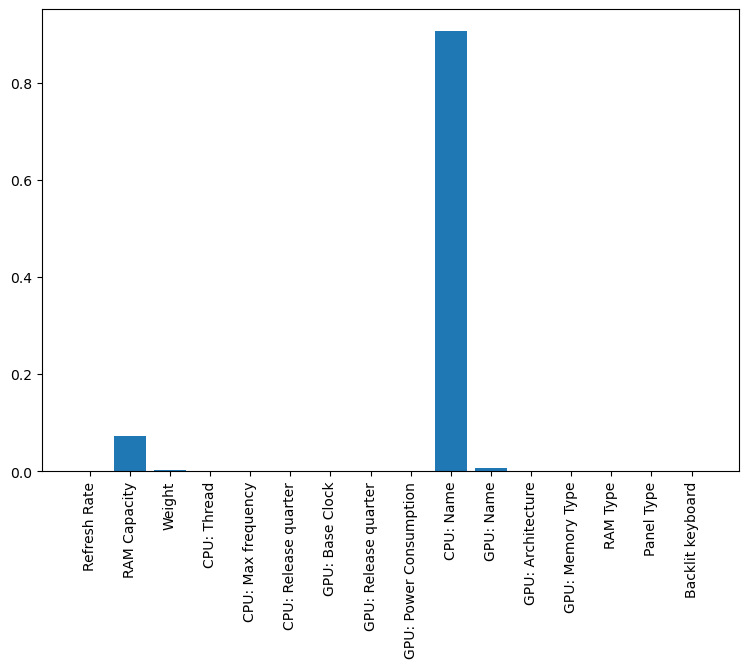

In [44]:
plt.figure(figsize=(9,6))
plt.bar(X_train.columns,random_forest.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [45]:
res["MLP Regressor"]=train(mlp)

In [47]:
table = PrettyTable()
table.field_names = ["Model","MAE","RMSE","R2 Score"]
for model in res.keys():
    table.add_row([model, res[model]["mae"],res[model]["rmse"],res[model]["r2_score"]])
print(table)

+-------------------------+---------------------+-----------------------+----------------------+
|          Model          |         MAE         |          RMSE         |       R2 Score       |
+-------------------------+---------------------+-----------------------+----------------------+
|    Linear Regression    | 0.22282124384702504 | {0.27361515474303505} | {0.9440224514128652} |
|          Ridge          | 0.22282127598917822 |  {0.2736151544075679} | {0.9440224515501283} |
| Random Forest Regressor | 0.09860136996851072 | {0.15289011535706162} | {0.9825219733896473} |
|      MLP Regressor      | 0.12191802743896321 |  {0.1745101704859346} | {0.9772293690224565} |
+-------------------------+---------------------+-----------------------+----------------------+


In [48]:
laptop_data_to_inference=X_test.join(laptop_data["link"])
laptop_data_to_inference


,Refresh Rate,RAM Capacity,Weight,CPU: Thread,CPU: Max frequency,CPU: Release quarter,GPU: Base Clock,GPU: Release quarter,GPU: Power Consumption,CPU: Name,GPU: Name,GPU: Architecture,GPU: Memory Type,RAM Type,Panel Type,Backlit keyboard,link
37544,0.943627,-0.197227,-0.279499,0.480996,0.022089,-0.412482,0.076108,0.123868,0.743524,7.405193,7.258734,7.346874,7.162982,5.997412,7.246209,1.0,https://laptopmedia.com/laptop-specs/asus-rog-...
101807,-0.676936,-0.197227,-0.320843,-0.231461,-0.769372,0.583330,-1.054966,-0.835744,-0.874757,6.012317,5.744017,5.865538,5.625279,5.997412,6.335125,1.0,https://laptopmedia.com/laptop-specs/asus-vivo...
23468,0.943627,1.931302,1.374245,1.193452,1.077369,0.583330,0.669922,0.123868,1.653807,7.925319,7.381457,7.331785,7.162982,7.603423,8.076386,1.0,https://laptopmedia.com/laptop-specs/dell-g16-...
15245,2.101172,-0.622933,0.340655,1.193452,2.132650,1.579142,1.150629,2.043090,1.249237,7.865211,7.652731,8.008238,7.162982,7.603423,6.335125,0.0,https://laptopmedia.com/laptop-specs/asus-rog-...
98696,0.619514,-0.622933,-0.362186,-0.231461,-0.241732,-1.408295,-0.278295,0.123868,-0.369044,6.403146,6.403407,6.837517,7.162982,5.997412,6.335125,1.0,https://laptopmedia.com/laptop-specs/msi-gf63-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46944,0.619514,1.931302,0.547373,0.480996,0.022089,-0.412482,0.994163,0.123868,1.451522,7.489181,7.519985,7.346874,7.162982,5.997412,7.246209,1.0,https://laptopmedia.com/laptop-specs/asus-rog-...
251814,3.953245,-0.622933,2.965973,1.193452,0.285909,0.583330,0.994163,0.123868,1.653807,7.689424,7.746198,7.346874,7.162982,5.997412,6.335125,1.0,https://laptopmedia.com/laptop-specs/msi-vecto...
229059,-0.676936,-0.622933,2.614553,-0.231461,1.077369,-1.159342,0.669922,-1.795355,1.148094,6.307514,6.465135,6.387688,7.162982,5.997412,6.335125,1.0,https://laptopmedia.com/laptop-specs/hp-omen-1...
134707,-0.676936,-0.622933,-0.630920,-0.943917,-0.241732,-0.163529,-1.054966,-0.355938,-0.874757,5.464851,5.430514,5.639518,5.625279,5.997412,6.335125,0.0,https://laptopmedia.com/laptop-specs/dell-insp...


In [ ]:
def predict(model,laptop_link):
    index=laptop_data_to_inference[laptop_data_to_inference["link"]==laptop_link].index[0]
    y_pred=model.predict(X_test.loc[index].values.reshape(1,-1))
    y_true=y_test.loc[index]
    print(f"Predicted {target}: ",y_pred[0])
    print(f"True {target}: ",y_true)

In [50]:
print(laptop_data_to_inference.index)
laptop_data_to_inference.loc[98696].link

Index([ 37544, 101807,  23468,  15245,  98696, 182945, 101903, 231306, 232699,
        16709,
       ...
       249763,  97607, 139003,  44105, 109566,  46944, 251814, 229059, 134707,
       230939],
      dtype='int64', length=69160)


'https://laptopmedia.com/laptop-specs/msi-gf63-thin-1330/'

In [55]:
predict(mlp,laptop_data_to_inference.loc[230939].link)

Predict Work Score:  6.446963459711465
True Work Score:  6.6


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
